# Tutorial 9: Regression Continued

**Regression learning objectives**: 

* Recognize situations where a simple regression analysis would be appropriate for making predictions.
* Explain the k-nearest neighbour (k-nn) regression algorithm and describe how it differs from k-nn classification.
* Interpret the output of a k-nn regression.
* In a dataset with two variables, perform k-nearest neighbour regression in R using `caret::train()` to predict the values for a test dataset.
* Using R, execute cross-validation in R to choose the number of neighbours.
* Using R, evaluate k-nn regression prediction accuracy using  a test data set and an appropriate metric (*e.g.*, root means square prediction error).
* In a dataset with > 2 variables, perform k-nn regression in R using `caret`'s `train` with `method = "knn"` to predict the values for a test dataset.
* In the context of k-nn regression, compare and contrast goodness of fit and prediction properties (namely RMSE vs RMSPE).
* Describe advantages and disadvantages of the k-nearest neighbour regression approach.
* Perform ordinary least squares regression in R using `caret`'s `train` with `method = "lm"` to predict the values for a test dataset.
* Compare and contrast predictions obtained from k-nearest neighbour regression to those obtained using simple ordinary least squares regression from the same dataset.
* In R, overlay the ordinary least squares regression lines from `geom_smooth` on a single plot. 

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(caret)
library(GGally)
source("tests_tutorial_09.R")
source("cleanup_tutorial_09.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘GGally’


The following object is masked from ‘package:dplyr’:

    nasa




## Predicting credit card balance

<img src='https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif' align="left" width='400'>

Source: https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif

Here in this worksheet we will work with a simulated data set that contains information that we can use to create a model to predict customer credit card balance. A bank might use such information to predict which customers might be the most profitable to lend to (customers who carry a balance, but do not default, for example).

Specifically, we wish to build a model to predict credit card balance (`Balance` column) based on income (`Income` column) and credit rating (`Rating` column).

**Question 1.0**
<br> {points: 1}

Load the data located at [this URL](http://faculty.marshall.usc.edu/gareth-james/ISL/Credit.csv) and assign it to an object called `credit`. 

In [2]:
# your code here
credit = read_csv("http://faculty.marshall.usc.edu/gareth-james/ISL/Credit.csv")
head(credit)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  X1 = col_double(),
  Income = col_double(),
  Limit = col_double(),
  Rating = col_double(),
  Cards = col_double(),
  Age = col_double(),
  Education = col_double(),
  Gender = col_character(),
  Student = col_character(),
  Married = col_character(),
  Ethnicity = col_character(),
  Balance = col_double()
)



X1,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
6,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151


In [3]:
test_1.0()

[1] "Success!"


**Question 1.1**
<br> {points: 1}

Select only the columns of data we are interested in using for our prediction (both the predictors and the response variable). Name the modified data frame `credit`.

In [4]:
# your code here
credit = credit %>%
    select(Balance, Income, Rating)
head(credit)

Balance,Income,Rating
<dbl>,<dbl>,<dbl>
333,14.891,283
903,106.025,483
580,104.593,514
964,148.924,681
331,55.882,357
1151,80.180,569


In [5]:
test_1.1()

[1] "Success!"


**Question 1.2**
<br> {points: 1}

Before we perform exploratory data analysis, we should create our training and testing data sets. We will use 60% of the data as training data. Use `set.seed(2000)` and use the `Balance` column as the input to `createDataPartition()`. 

At the end of this question you should have 4 objects named `X_train`, `Y_train`, `X_test` and `Y_test`.

In [43]:
set.seed(2000)
# your code here
training_rows = credit %>%
    select(Balance) %>%
    unlist() %>%
    createDataPartition(p = 0.6, list = F)
X_train = credit %>%
    select(-Balance) %>%
    slice(training_rows) %>%
    data.frame()
Y_train = credit %>%
    select(Balance) %>%
    slice(training_rows) %>%
    unlist()
X_test = credit %>%
    select(-Balance) %>%
    slice(-training_rows) %>%
    data.frame()
Y_test = credit %>%
    select(Balance) %>%
    slice(-training_rows) %>%
    unlist()

In [44]:
test_1.2()

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Using only the observations in the data set, create a `ggpairs` scatterplot of all the columns we are interested in including in our model. Name the plot object `credit_eda`.

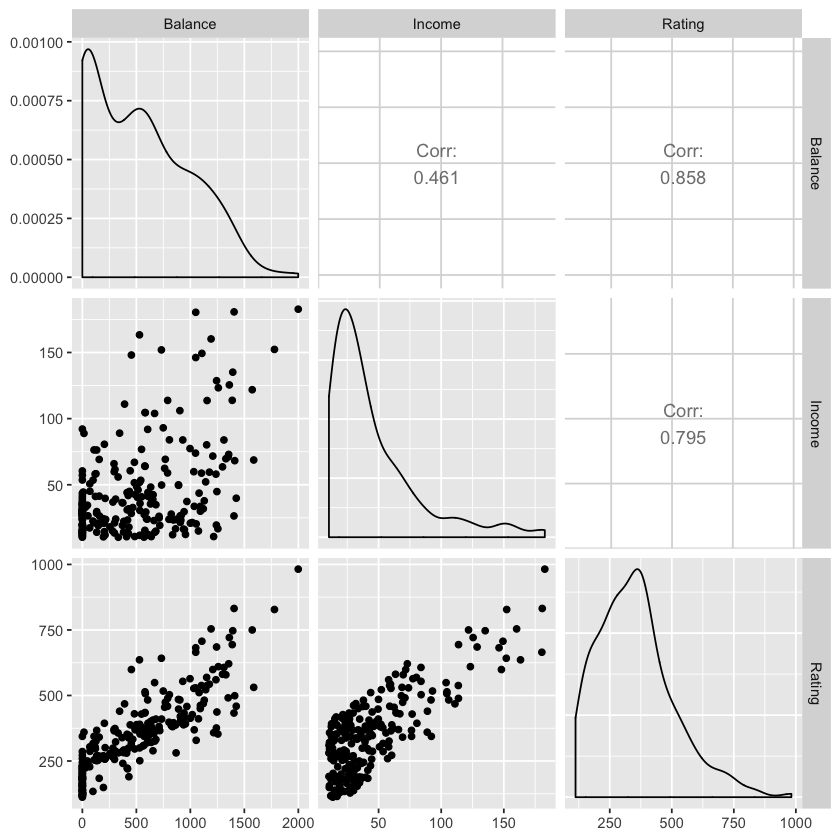

In [54]:
# your code here
credit_eda = credit %>%
    slice(training_rows) %>%
    ggpairs()
credit_eda

In [55]:
test_1.3()

[1] "Success!"


**Question 1.4**
<br> {points: 3}

Discuss the relationship you observe in the scatter plots above between the response variable and each predictor.

In this study, we are looking at the following variables:

- Explanatory variables: Income, Credit Rating
- Response variable: Credit Card Balance

As seen in the ggpairs matrix above, `Income` and `Rating` are positively correlated with `Balance`.

**Question 1.5**
<br> {points: 1}

Now use `caret`'s `train` function with `method = "lm"` to fit your linear regression model. Name your linear regression model object `lm_model`.

In [56]:
# your code here
lm_model = train(x=X_train, y=Y_train, method="lm")
lm_model

Linear Regression 

241 samples
  2 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 241, 241, 241, 241, 241, 241, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  169.9831  0.8653802  130.2069

Tuning parameter 'intercept' was held constant at a value of TRUE

In [57]:
test_1.5()

[1] "Success!"


**Question 1.6**
<br> {points: 1}

Let's print out a table of the regression slopes/coefficients. To do this, we want to access some attributes of the model object. We provide scaffolding below. To get the slopes/coefficients as a nice data frame, we then use the `t()` (transpose) function to pivot the data, and then `data.frame()` to convert it to a data frame. Name the resultant data frame `lm_coeffs`.

In [65]:
# ... <- ...$finalModel$coefficients %>%
#   ... %>%
#    data.frame()
# colnames(lm_coeffs)[1] <- "Intercept"

# your code here
lm_coeffs <- lm_model$finalModel$coefficients %>%
    t() %>%
    data.frame()
colnames(lm_coeffs)[1] <- "Intercept"
lm_coeffs

Intercept,Income,Rating
<dbl>,<dbl>,<dbl>
-531.4406,-7.583581,3.944298


In [63]:
test_1.6()

[1] "Success!"


**Question 1.7**
<br> {points: 3}

Looking at the slopes/coefficients above from each of the predictors, write a mathematical equation for your prediction model.

A couple hints:
- surrounding your equation with `$` signs in a markdown cell, makes it a LaTeX equation
- to add white space in a LaTeX equation, use `\:`

$Balance = (-7.583581) * Income + (3.944298) * Rating + (-531.4406)$

**Question 1.8**
<br> {points: 1}

Calculate the $RMSE$ to assess goodness of fit on your `lm_model` (remember this is how well it predicts on the training data used to fit the model). Return a single numerical value named `lm_rmse`.

In [66]:
# your code here
train_pred = predict(lm_model, X_train)
lm_modelvalues = data.frame(obs = Y_train, pred = train_pred)
lm_rmse = defaultSummary(lm_modelvalues)[[1]]
lm_rmse

[1] 166.3225

In [67]:
test_1.8()

[1] "Success!"


**Question 1.9**
<br> {points: 1}

Calculate $RMSPE$ using the test data. Return a single numerical value named `lm_rmspe`.

In [68]:
# your code here
test_pred = predict(lm_model, X_test)
lm_testvalues = data.frame(obs = Y_test, pred = test_pred)
lm_rmspe = defaultSummary(lm_testvalues)[[1]]
lm_rmspe

[1] 156.2316

In [69]:
test_1.9()

[1] "Success!"


**Question 1.9.1**
<br> {points: 3}

Redo this analysis using k-nn regression instead of linear regression. Use `set.seed(2000)` at the beginning of this code cell to make it reproducible. Assign a single numeric value for $RMSPE$ for your k-nn model as your answer, and name it `knn_rmspe`. Use the same predictors and train - test data split as you used for linear regression, and use 5-fold cross validation to choose $k$ from the range 1-20. Remember to scale and shift your variables using `preProcess` on your training data, and to apply that same standardization to your test data!

In [89]:
set.seed(2000)
# your code here
train_control = trainControl(method = "cv", number = 5)
k_lots = data.frame(k = seq(from = 1, to = 20, by = 1))

knn_reg_cv_5 = train(x = X_test,
                    y = Y_test,
                    method = "knn",
                    tuneGrid = k_lots,
                    trControl = train_control)

optimal_k = knn_reg_cv_5$results %>%
    filter(RMSE == min(RMSE)) %>%
    select(k)

knn_model = train(x=X_train, 
                  y=Y_train, 
                  method="knn", 
                  tuneGrid=optimal_k, 
                  trControl=train_control)

test_pred = predict(knn_model, X_test) 
knn_testvalues = data.frame(obs = Y_test, pred = test_pred)
knn_rmspe = defaultSummary(knn_testvalues)[[1]]

knn_rmspe

[1] 171.4771

**Question 1.9.2** 
<br> {points: 3}

Discuss which model gives better predictions and why you think that might be happening.

In this scenario, the linear model resulted in a lower root mean squared percentage error (RMSPE) than the k-nearest neighbour model. 

- RMSPE-lm: 156.23
- RMSPE-knn: 171.48

Looking at the `ggpairs()` matrix in 1.3, I can visually see that `Balance` vs `Rating` has a strong correlation while `Balance` vs `Income` has a moderate-to-weak correlation. The weaker correlation in the latter relationship may create additional noise when predicting `Balance` using knn as opposed to using lm.

## 2. Ames Housing Prices

<img src="https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif

If we take a look at the Business Insider report [What do millenials want in a home?](https://www.businessinsider.com/what-do-millennials-want-in-a-home-2017-2), we can see that millenials like newer houses that have their own defined spaces. Today we are going to be looking at housing data to understand how the sale price of a house is determined. Finding highly detailed housing data with the final sale prices is very hard, however researchers from Truman State Univeristy have studied and made available a dataset containing multiple variables for the city of Ames, Iowa. The data set describes the sale of individual residential property in Ames, Iowa
from 2006 to 2010. You can read more about the data set [here](http://jse.amstat.org/v19n3/decock.pdf). Today we will be looking at 5 different variables to predict the sale price of a house. These variables are: 

- Lot Area: `lot_area`
- Year Built: `year_built`
- Basement Square Footage: `bsmt_sf`
- First Floor Square Footage: `first_sf`
- Second Floor Square Footage: `second_sf`

We are going to be looking at two approaches, linear regression and KNN regression. First, load the data with the script given below. 

In [90]:
ames_data <- read_csv('data/ames.csv', col_types = cols()) %>%
    select(lot_area = Lot.Area, 
           year_built = Year.Built, 
           bsmt_sf = Total.Bsmt.SF, 
           first_sf = `X1st.Flr.SF`, 
           second_sf = `X2nd.Flr.SF`, 
           sale_price = SalePrice) %>%
    filter(!is.na(bsmt_sf))

head(ames_data)

Warning message:
“13 parsing failures.
 row     col           expected actual            file
1064 Pool.QC 1/0/T/F/TRUE/FALSE     Ex 'data/ames.csv'
1499 Pool.QC 1/0/T/F/TRUE/FALSE     Gd 'data/ames.csv'
1567 Pool.QC 1/0/T/F/TRUE/FALSE     Gd 'data/ames.csv'
1761 Pool.QC 1/0/T/F/TRUE/FALSE     Ex 'data/ames.csv'
1941 Pool.QC 1/0/T/F/TRUE/FALSE     TA 'data/ames.csv'
.... ....... .................. ...... ...............
See problems(...) for more details.
”


lot_area,year_built,bsmt_sf,first_sf,second_sf,sale_price
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
31770,1960,1080,1656,0,215000
11622,1961,882,896,0,105000
14267,1958,1329,1329,0,172000
11160,1968,2110,2110,0,244000
13830,1997,928,928,701,189900
9978,1998,926,926,678,195500


**Question 2.1**
<br> {points: 3}

Split the data into a train dataset and a test dataset, based on a 70%-30% train-test split. Use `set.seed(2019)`. Remember that we want to predict the `sale_price` based on all of the other variables. 

Assign the objects to `X_train`, `Y_train`, `X_test`, and `Y_test` respectively. 

*Use 2019 as your seed for the split.*

In [101]:
set.seed(2019) # DO NOT CHANGE!
# your code here
training_rows = ames_data %>%
    select(sale_price) %>%
    unlist() %>%
    createDataPartition(p = 0.7, list = F)

X_train = ames_data %>%
    select(-sale_price) %>%
    slice(training_rows) %>%
    data.frame()
Y_train = ames_data %>%
    select(sale_price) %>%
    slice(training_rows) %>%
    unlist()
X_test = ames_data %>%
    select(-sale_price) %>%
    slice(-training_rows) %>%
    data.frame()
Y_test = ames_data %>%
    select(sale_price) %>%
    slice(-training_rows) %>%
    unlist()

In [95]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create objects named X_train, Y_train, X_test, Y_test', {
    expect_true(exists("X_train")) 
    expect_true(exists("Y_train")) 
    expect_true(exists("X_test")) 
    expect_true(exists("Y_test")) 
    })

**Question 2.2**
<br> {points: 3}

Let's start by exploring the training data. Use the `ggpairs()` function from the GGally package to explore the relationships between the different variables. 

Assign your plot object to a variable named `answer2.2`. 

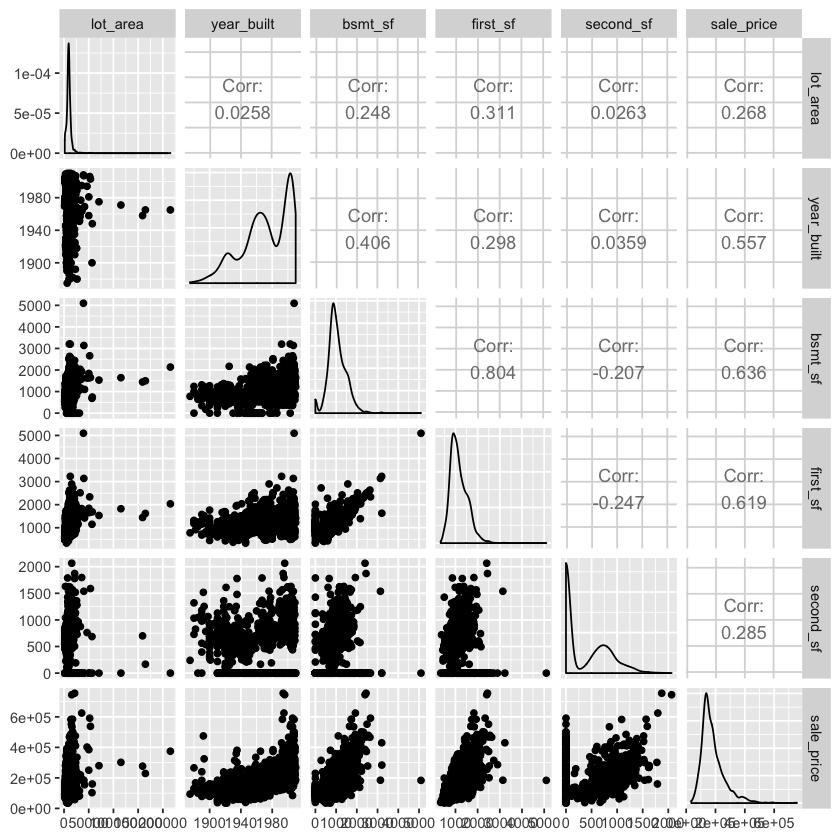

In [103]:
# your code here
answer2.2 = ames_data %>%
    slice(training_rows) %>%
    ggpairs()
answer2.2

In [104]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create a plot named answer2.2', {
    expect_true(exists("answer2.2")) 
})


**Question 2.3**
<br> {points: 3}

Now that we have seen the multiple relationships between the variables, which one(s) do you think will be strong predictors for `sale_price`? On what do you base this? If you think none would be good predictors, explain why.

Response:

As seen in the ggpairs() plot above in question 2.2, `sale_price` has the strongest correlations with `year_built`, `bsmt_sf`, `first_sf`. 

The remaining predictors/explanatory variables (which includes `lot_area`, `second_sf`) have lower correlations and will be weak predictors for `sale_price`.

These remarks come from visual observation of the scatter plots and of the correlation coefficients. The three former predictors (with the strongest correlations) have correlation _(r)_ coefficients of: 

$$r > 0.5$$

which is in contrast to the latter two with lower $r$ coefficients of:

$$r <= 0.5$$

**Question 2.4 - Linear Regression**
<br> {points: 3}

Fit a linear regression model with `X_train` and `y_train` using **all** the variables in the data set and save it to an object called `lm_reg`. Extract the coefficients of the model and assign them to an object named lm_coefs. 

In [120]:
# your code here
lm_reg = train(x=X_train, y=Y_train, method='lm')
lm_coefs = lm_model$finalModel$coefficients %>%
    t() %>%
    data.frame()
lm_coefs

X.Intercept.,lot_area,year_built,bsmt_sf,first_sf,second_sf
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1649585,0.5364361,838.2622,46.53283,83.42973,79.08737


In [114]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named lm_reg', {
    expect_true(exists("lm_reg")) 
    })
test_that('Did not create an object named lm_coefs', {
    expect_true(exists("lm_coefs")) 
    })


**Question 2.5**
<br> {points: 3}

Provide a brief interpretation of the coefficients above and discuss the relationship between `sale_price` and each variable (i.e., does the slope indicate a positive or negative relationship between house sale price and each of the predictors). 

*You don't have to interpret the intercept.* 

Response:

The slopes of `lot_area` `year_built` `bsmt_sf` `first_sf` `second_sf` all are positive and indicate positive relationships with `sale_price`. 

In other words, an increase in the values of each predictor correlates with an increase in `sale_price`.

**Question 2.6**
<br> {points: 3}

Use the coefficients above to write a mathematical equation for your prediction model. You can round the coefficients to two decimal places for this. 

Response:

$$sale\_price = -1649585 + 0.54 * lot\_area + 838.26 * year\_built + 46.53 * bsmt\_sf + 83.43 * first\_sf + 79.09 * second\_sf$$

**Question 2.7** 
<br> {points: 3}

Could we easily visualize the predictions of the model above as a line or a plane in a single plot? If so, explain how. If not, explain why not.

Response:

**\> No**

We cannot easily visualize the predictions of the model above as a line or plane in a single plot. The maximum number of predictors in which we can plot in a graph is **2**. 

It is possible to __plot a 2D line with 1 predictor__ and to __plot a 3D plane with 2 predictors__.

**Question 2.8**
<br> {points: 3}

We need to evaluate how well our model is doing. For this calculate the **RMSPE** of the linear regression model and assign it to an object named `lm_rmspe`.

In [121]:
# your code here
test_pred = predict(lm_reg, X_test)
lm_testvalues = data.frame(obs = Y_test, pred = test_pred)
lm_rmspe = defaultSummary(lm_testvalues)[[1]]
lm_rmspe

[1] 44407.71

In [122]:
# We check that you've created objects with the right names below
# But all other tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.
test_that('Did not create an object named lm_rmspe', {
    expect_true(exists("lm_rmspe")) 
    })

**Question 2.9**
<br> {points: 3}

Above we calculated $RMSPE$ to assess how well our model predicts on new data. Why did we not calculate $RMSE$ to answer that question? (*hint - think of the definitions of $RMSE$ and $RMSPE$*)

Response:

RMSE, the root mean squared error, is used as a measurement of the quality of the prediction data. Since we are using linear regression and not fine-tuning the k value (as we did with the k-nearest-neighbour method), there is no need to assess the accuracy of the in-sample data.

This question is concerned at predicting future, out-of-sample data, hence why we are only concerned about the root mean squared **prediction** error (RMPSE).

**Question 2.10**
<br> *(optional)*

"Logarithmically transforming variables in a regression model is a very common way to handle situations where a non-linear relationship exists between the independent and dependent variables. Using the logarithm of one or more variables instead of the un-logged form makes the effective relationship non-linear, while still preserving the linear model." - [Linear Regression Models with Logarithmic Transformations](https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf)

Take the logarithm of the `sale_price` variable and fit your linear model again. Do you have a lower RMSPE? Do you have the same model as in question 1.4?